In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses, metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
# Dataset configuration
TRAIN_DIR = 'K:/Deeplearning_dataset/casting_data/train'
VAL_DIR = 'K:/Deeplearning_dataset/casting_data/test'
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# Load datasets
train_dataset = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)
val_dataset = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
)
class_names = train_dataset.class_names

# Split validation dataset into validation and test datasets
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches // 5)
val_dataset = val_dataset.skip(val_batches // 5)

print(f"Training batches: {tf.data.experimental.cardinality(train_dataset)}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_dataset)}")
print(f"Test batches: {tf.data.experimental.cardinality(test_dataset)}")

Found 6633 files belonging to 2 classes.
Found 715 files belonging to 2 classes.
Training batches: 208
Validation batches: 19
Test batches: 4


In [9]:
# Get image shape from dataset sample
for images, _ in train_dataset.take(1):
    input_shape = images[0].shape

# Optimize dataset loading
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
from tensorflow.keras.applications import Xception

base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False
base_model.summary()

# Build the fine-tuning model
inputs = keras.Input(shape=input_shape)
x = keras.applications.xception.preprocess_input(inputs)  
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(units=1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

In [5]:
# Compile the model
initial_learning_rate = 0.0001
model.compile(
    optimizer=optimizers.Adam(learning_rate=initial_learning_rate),
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=[metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

# Train the model
initial_epochs = 10
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
)

Epoch 1/10


I0000 00:00:1734439283.862274      92 service.cc:145] XLA service 0x7c5c400028d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734439283.862324      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/208 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.4531 - loss: 0.8220   

I0000 00:00:1734439290.743371      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


208/208 ━━━━━━━━━━━━━━━━━━━━ 48s 127ms/step - accuracy: 0.5954 - loss: 0.6693 - val_accuracy: 0.7871 - val_loss: 0.5113
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.7624 - loss: 0.5310 - val_accuracy: 0.8450 - val_loss: 0.4338
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.8356 - loss: 0.4604 - val_accuracy: 0.8927 - val_loss: 0.3822
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.8511 - loss: 0.4150 - val_accuracy: 0.9097 - val_loss: 0.3458
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.8846 - loss: 0.3704 - val_accuracy: 0.9182 - val_loss: 0.3170
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - accuracy: 0.9024 - loss: 0.3376 - val_accuracy: 0.9216 - val_loss: 0.2944
Epoch 7/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.9144 - loss: 0.3169 - val_accuracy: 0.9336 - val_loss: 0.2764
Epoch 8/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - accuracy: 0.9217 - loss: 0.2932 - val_accura

In [6]:
# Fine-tune the model
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

fine_tune_learning_rate = initial_learning_rate / 10
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=fine_tune_learning_rate),
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=[metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    validation_data=val_dataset,
    initial_epoch=history.epoch[-1],
)

Epoch 10/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.8013 - loss: 0.3934 - val_accuracy: 0.9847 - val_loss: 0.0513
Epoch 11/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9902 - loss: 0.0533 - val_accuracy: 0.9932 - val_loss: 0.0199
Epoch 12/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9968 - loss: 0.0217 - val_accuracy: 0.9949 - val_loss: 0.0258
Epoch 13/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9970 - loss: 0.0165 - val_accuracy: 0.9949 - val_loss: 0.0196
Epoch 14/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9973 - loss: 0.0111 - val_accuracy: 0.9966 - val_loss: 0.0121
Epoch 15/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9988 - loss: 0.0067 - val_accuracy: 0.9949 - val_loss: 0.0144
Epoch 16/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9992 - loss: 0.0057 - val_accuracy: 0.9949 - val_loss: 0.0120
Epoch 17/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 22s 104ms/step - accuracy: 0.9997 -

In [7]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: %{test_accuracy * 100}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 0.0012   
Test accuracy: %100.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Confusion Matrix:
 [[84  0]
 [ 0 44]]


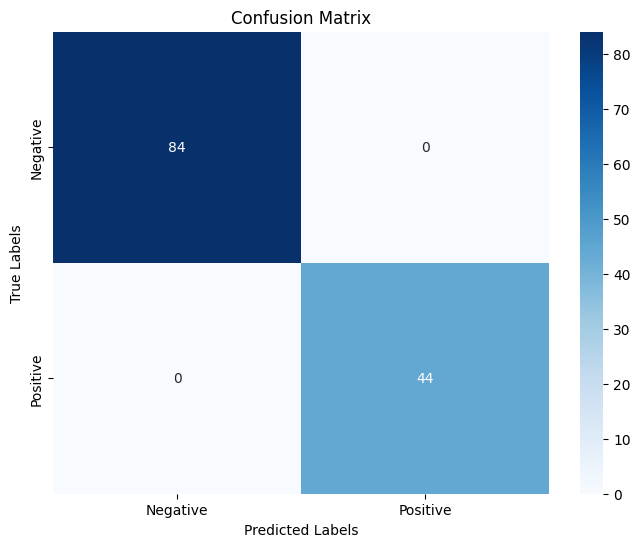

In [8]:
# Collect true and predicted values
y_true, y_pred = [], []
for x, y in test_dataset:
    y_true.extend(y.numpy())
    y_pred.extend(model.predict(x))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert probabilities to class predictions
y_pred_class = (y_pred > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [9]:
# Metrics
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 1.00
Recall: 1.00
F1 Score: 1.00


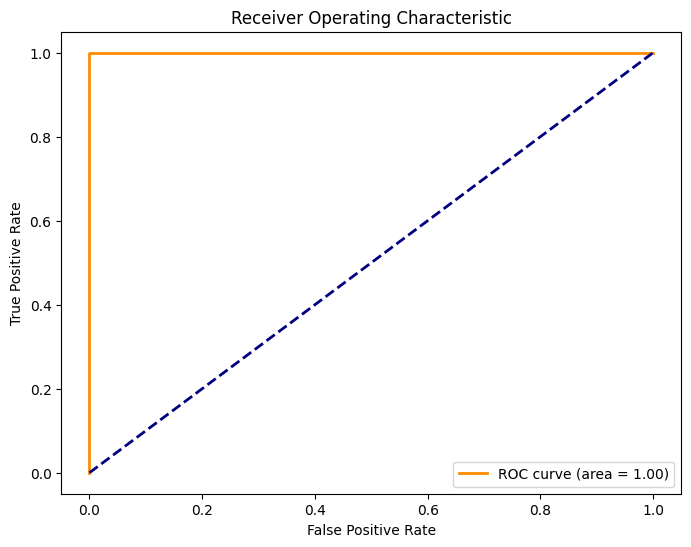

In [10]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [13]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
base_model.summary()

# Build the fine-tuning model
inputs = keras.Input(shape=input_shape)
x = keras.applications.densenet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(units=1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_4 (ZeroPadd  (None, 230, 230, 3)          0         ['input_5[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_4[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

In [12]:
# Compile the model
initial_learning_rate = 0.0001
model.compile(
    optimizer=optimizers.Adam(learning_rate=initial_learning_rate),
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=[metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

# Train the model
initial_epochs = 10
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
)

Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 59s 174ms/step - accuracy: 0.5759 - loss: 0.6908 - val_accuracy: 0.7853 - val_loss: 0.5497
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.6976 - loss: 0.5639 - val_accuracy: 0.8688 - val_loss: 0.4521
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.7869 - loss: 0.4860 - val_accuracy: 0.9114 - val_loss: 0.3918
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8381 - loss: 0.4249 - val_accuracy: 0.9284 - val_loss: 0.3478
Epoch 5/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.8608 - loss: 0.3788 - val_accuracy: 0.9421 - val_loss: 0.3136
Epoch 6/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.8868 - loss: 0.3419 - val_accuracy: 0.9574 - val_loss: 0.2831
Epoch 7/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9005 - loss: 0.3169 - val_accuracy: 0.9489 - val_loss: 0.2624
Epoch 8/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9172 - loss: 0.2896 -

In [13]:
# Fine-tune the model
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

fine_tune_learning_rate = initial_learning_rate / 10
model.compile(
    optimizer=optimizers.RMSprop(learning_rate=fine_tune_learning_rate),
    loss=losses.BinaryCrossentropy(from_logits=False),
    metrics=[metrics.BinaryAccuracy(threshold=0.5, name="accuracy")],
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_fine_tune = model.fit(
    train_dataset,
    epochs=total_epochs,
    validation_data=val_dataset,
    initial_epoch=history.epoch[-1],
)

Epoch 10/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 171s 405ms/step - accuracy: 0.9360 - loss: 0.1588 - val_accuracy: 0.9915 - val_loss: 0.0379
Epoch 11/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.9955 - loss: 0.0172 - val_accuracy: 0.9949 - val_loss: 0.0149
Epoch 12/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.9993 - loss: 0.0048 - val_accuracy: 0.9949 - val_loss: 0.0134
Epoch 13/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 118ms/step - accuracy: 0.9997 - loss: 0.0024 - val_accuracy: 0.9983 - val_loss: 0.0103
Epoch 14/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9966 - val_loss: 0.0108
Epoch 15/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 1.0000 - loss: 6.4161e-04 - val_accuracy: 0.9983 - val_loss: 0.0105
Epoch 16/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy: 1.0000 - loss: 3.8043e-04 - val_accuracy: 0.9983 - val_loss: 0.0092
Epoch 17/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - accuracy:

In [14]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: %{test_accuracy * 100}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 3.1792e-05
Test accuracy: %100.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Confusion Matrix:
 [[84  0]
 [ 0 44]]


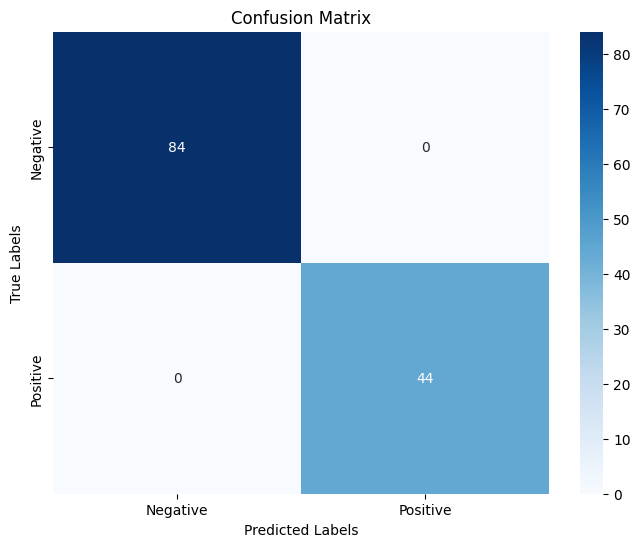

In [15]:
# Collect true and predicted values
y_true, y_pred = [], []
for x, y in test_dataset:
    y_true.extend(y.numpy())
    y_pred.extend(model.predict(x))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Convert probabilities to class predictions
y_pred_class = (y_pred > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_class)
print("Confusion Matrix:\n", conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Metrics
precision = precision_score(y_true, y_pred_class)
recall = recall_score(y_true, y_pred_class)
f1 = f1_score(y_true, y_pred_class)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 1.00
Recall: 1.00
F1 Score: 1.00


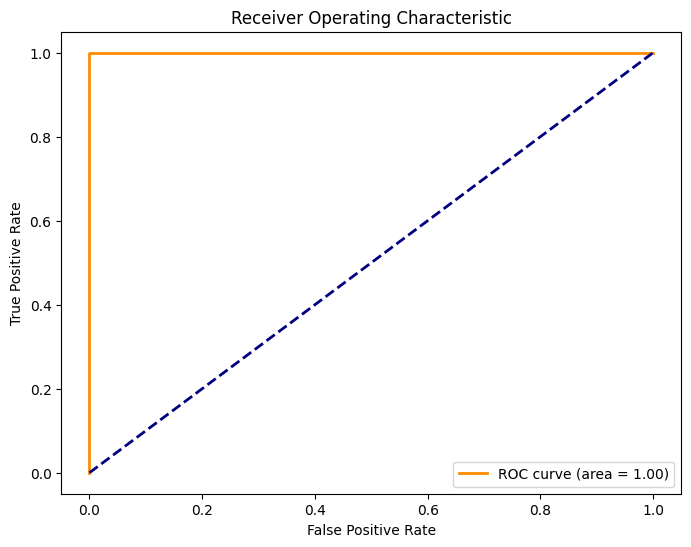

In [17]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()